<h1 style="text-align:center;">Six Nations Rugby Drama:<br> Analyzing YouTube Reactions to Controversial Try Decision <br>Did France Deserve the Win or Was Scotland Robbed?</h1>

<p style="text-align:center; font-size:large;">Created By: Christopher Castor</p>

## Overview
The 2024 Six Nations rugby match between Scotland and France delivered a gripping and controversial moment in the final minutes, where an inconclusive last-gasp try review determined the outcome. As on-field referee Nic Berry called no-try despite potential evidence suggesting otherwise, the match concluded with France holding on to a tense victory. This pivotal decision has sparked widespread discussions and debates among rugby enthusiasts and fans.

This Jupyter notebook seeks to explore and analyze public sentiment surrounding this contentious last-minute call using the comments section of the [official Six Nations YouTube highlight video](https://www.youtube.com/watch?v=Rcst-jIOQDo). The goal is to determine whether the majority of viewers agree with the no-try decision by leveraging OpenAI and sentiment analysis techniques. 

## Data
Data was collected using the Google YouTube API to extract reactions from the highlight video. The API grants access and retrieves comments, replies, and likes associated with the video, providing valuable insights into the diverse reactions and opinions of the viewers. Then, the comments and replies were evaluated using OpenAI's API to determine sentiment towards the contentious last-minute call.

## Table of Contents

- <a href='#1'> 1. Import Libraries</a>
- <a href='#2'> 2. Define Functions</a>
- <a href='#3'> 3. Retrieve and Clean Data</a>
- <a href='#4'> 4. Determine Sentiment</a>

# <a id='1'>1. Import Libraries</a>

In [34]:
# Import libraries
import pandas as pd
from googleapiclient.discovery import build
from dotenv import load_dotenv
import os
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from openai import OpenAI
import html
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
from wordcloud import WordCloud
import numpy as np
from translate import Translator

# Load spaCy model with TextBlob capabilities
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")


# Import API Key and Video ID
load_dotenv()
api_key = os.getenv('API_KEY')
video_id = os.getenv('VIDEO_ID')

# Initialize OpenAI client
client = OpenAI(api_key = os.getenv('OPENAI_KEY'))

# <a id='2'>2. Define Functions</a>

In [23]:
def generate_decision(prompt):
    '''
    Generate a decision using OpenAI's chat model.

    Parameters:
    - prompt (str): The input prompt for the chat model.

    Returns:
    - decision (str): The generated decision based on the prompt.
    '''
    # Create chat completion with the given prompt
    response = client.chat.completions.create(
        model = "gpt-3.5-turbo",
        messages=[{'role':'user', 'content':prompt}]
    )

    decision = response.choices[0].message.content

    return decision

In [24]:
def get_decisions(common_prompt, comment, replies):
    '''
    Generate decisions for a main comment and its replies using OpenAI's chat model.

    Parameters:
    - common_prompt (str): The main prompt to include before each video reaction
    - comment (str): The main comment for which a decision is generated.
    - replies (list): A list of replies to the main comment.

    Returns:
    - comment_decision (str): The generated decision for the main comment.
    - replies_decisions (list): A list of generated decisions for each reply.
    '''
    # Generate decision for the main comment
    comment_prompt = common_prompt + comment
    comment_decision = generate_decision(comment_prompt)

    # Generate decisions for each reply
    replies_decisions = []
    for reply in replies:
        reply_prompt = common_prompt + reply
        reply_decision = generate_decision(reply_prompt)
        replies_decisions.append(reply_decision)


    return comment_decision, replies_decisions

In [46]:
def clean_text(text):
    '''
    Clean and decode HTML entities from the input text.

    Parameters:
    - text (str): The text to be cleaned.

    Returns:
    - translated_text (str): The text after cleaning and decoding HTML entities.
    '''
    return html.unescape(text)

In [26]:
def video_reactions(video_id, api_key):
	'''
	Retrieve comments and reactions data for a YouTube video.

	Parameters:
	- video_id (str): The YouTube video ID.
	- api_key (str): The YouTube Data API key.

	Returns:
	- df (DataFrame): DataFrame containing comments, replies, likes, and reply counts.
	'''
	# Create a list to store comments and related information
	comments_data = []

	# Create YouTube resource object
	youtube = build('youtube', 'v3', developerKey=api_key)

	# Retrieve YouTube video comments and replies
	video_response=youtube.commentThreads().list(
	part='snippet,replies',
	videoId=video_id
	).execute()

	# Iterate through video comments and replies
	while video_response:
	
		# Extract information from each object
		for item in video_response['items']:
		
			# Extract comment text
			comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
			
			# Extract number of likes for each comment
			likes_count = item['snippet']['topLevelComment']['snippet']['likeCount']

			# Extract number of replies to each comment
			reply_count = item['snippet']['totalReplyCount']

			# Extract replies if available
			if reply_count > 0:
				replies = [reply['snippet']['textDisplay'] for reply in item['replies']['comments']]
			else:
				replies = []

			# Append information to the list
			comments_data.append({'Comment': comment_text, 'Replies': replies, 'Like_Count': likes_count, 'Reply_Count': reply_count})

		# Repeat for the next page if available
		if 'nextPageToken' in video_response:
			video_response = youtube.commentThreads().list(
					part = 'snippet,replies',
					videoId = video_id,
					pageToken = video_response['nextPageToken']
				).execute()
		else:
			break

	# Create DataFrame containing comments and related information
	df = pd.DataFrame(comments_data)

	return df

# <a id='3'>3. Retrieve and Clean Data</a>

In [37]:
# Retrieve comments, likes, and replies data from the YouTube video
reaction_df = video_reactions(video_id, api_key)

# Clean text in the 'Comment' and 'Replies' column
reaction_df['Comment'] = reaction_df['Comment'].apply(clean_text)
reaction_df['Replies'] = reaction_df['Replies'].apply(lambda replies: [clean_text(reply) for reply in replies])

# Display summary statistics
print('Comments: {}, Replies: {}, Total: {}'.format(len(reaction_df), reaction_df['Reply_Count'].sum(), len(reaction_df)+reaction_df['Reply_Count'].sum()))

Comments: 431, Replies: 362, Total: 793


# <a id='4'>4. Determine Sentiment</a>

In [ ]:
# Create a common prompt to be used for generating decisions
common_prompt = '''
 Scotland were denied victory by an inconclusive last-gasp try review as France held on to win a tense Six Nations rugby encounter. Replays suggested the ball was grounded by Sam Skinner but the on-field referee, Nic Berry, had called no-try and the Television Match Official (TMO), Brian MacNeice, claimed to not have the evidence to conclusively prove otherwise. I want you to analyze the following text and determine whether they agree with the no-try decision meaning France fairly, deservedly won the game (0) or whether they disagree with the no-try decision meaning it was a try and Scotland was robbed and deserved to win (1). I only want you to reply to this with a 0 or a 1 but if you really can't make a decision then reply "Unknown".
 '''

# Generate decisions for each comment and its replies
reaction_df[['Comment_Decision','Replies_Decisions']] = reaction_df.apply(lambda row: get_decisions(common_prompt, row['Comment'], row['Replies']), axis=1, result_type='expand')

In [69]:
test_random_values = np.random.choice(['Agree','Disagree','Unknown'], size=len(reaction_df), p=[0.35, 0.60, 0.05])
reaction_df['Comment_Decision'] = test_random_values

def random_assignment():
    return np.random.choice(['Agree']*20+['Disagree']*78+['Unknown']*2)

reaction_df['Replies_Decisions'] = reaction_df['Replies'].apply(lambda x: [random_assignment() for _ in range(len(x))] if x else [])

In [70]:
reaction_df.tail()

,Comment,Replies,Like_Count,Reply_Count,Comment_Decision,Replies_Decisions
426,"worst decision ever, balls on the ground you c...","[Completely agree, it just seems daft to me in...",41,3,Disagree,"[Disagree, Agree, Unknown]"
427,Like if Scotland were robbed,"[What do you mean. It was a obvious try, If th...",1307,42,Disagree,"[Disagree, Agree, Disagree, Disagree, Disagree]"
428,Robbery,[],5,0,Disagree,[]
429,Robbed again,[],4,0,Agree,[]
430,First 🖤,[],1,0,Disagree,[]


# <a id='5'>5. Sentiment Distribution</a>

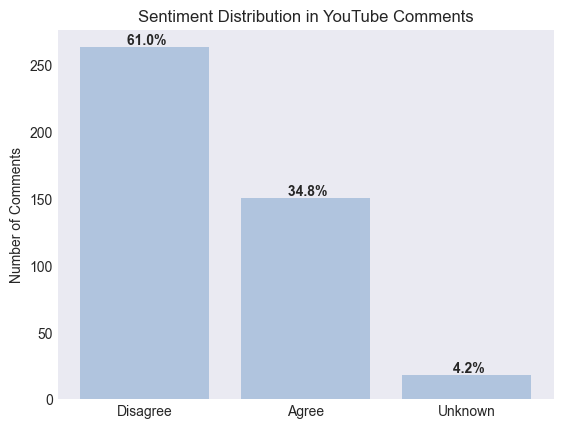

In [73]:
# Calculate value counts and percentages
value_counts = reaction_df['Comment_Decision'].value_counts()
percentages = (value_counts / len(reaction_df)) * 100

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts, color='lightsteelblue')

# Display percentages above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage: .1f}%', ha='center', va='bottom', weight='bold')

# Set labels and title 
ax.set_ylabel('Number of Comments')
ax.set_title('Sentiment Distribution in YouTube Comments')

plt.show()

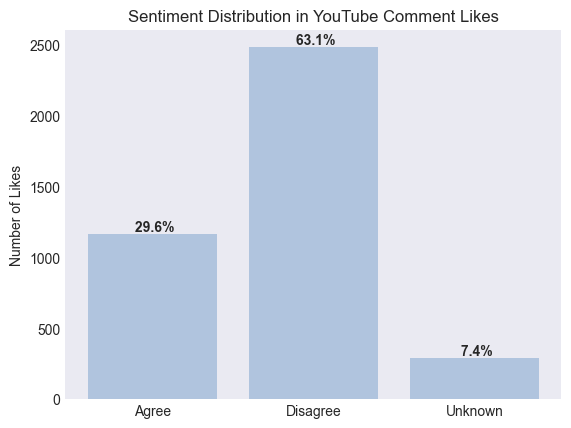

In [99]:
# Calculate value counts and percentages
value_counts = reaction_df['Like_Count'].groupby(reaction_df['Comment_Decision']).sum()
percentages = (value_counts / (reaction_df['Like_Count'].groupby(reaction_df['Comment_Decision']).sum()).sum()) * 100

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts, color='lightsteelblue')

# Display percentages above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage: .1f}%', ha='center', va='bottom', weight='bold')

# Set labels and title 
ax.set_ylabel('Number of Likes')
ax.set_title('Sentiment Distribution in YouTube Comment Likes')

plt.show()

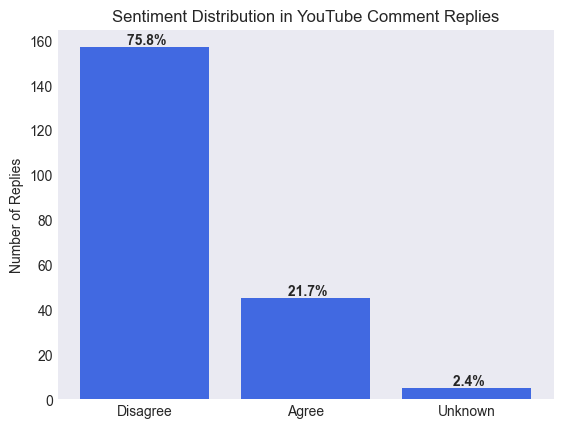

In [97]:
# Calculate value counts and percentages
value_counts = reaction_df[reaction_df['Replies_Decisions'].apply(lambda x: len(x) > 0)]['Replies_Decisions'].explode().value_counts()
percentages = (value_counts / value_counts.sum()) * 100

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts, color='royalblue')

# Display percentages above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage: .1f}%', ha='center', va='bottom', weight='bold')

# Set labels and title 
ax.set_ylabel('Number of Replies')
ax.set_title('Sentiment Distribution in YouTube Comment Replies')

plt.show()

# <a id='6'>6. Word Clouds</a>

In [91]:
def clean_text_word_cloud_word(text):
    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [94]:
def clean_text_word_cloud_phrase(text):
    doc = nlp(text)
    cleaned_tokens = [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [95]:
def generate_word_cloud(comments, title, stopwords):
    # cleaned_comments = [clean_text_word_cloud(comment) for comment in comments]
    cleaned_comments = [clean_text_word_cloud_phrase(comment) for comment in comments]

    if stopwords:
        wordcloud = WordCloud(width=800, height=400, max_words=1000, background_color='white', stopwords=stopwords).generate(' '.join(cleaned_comments))
    else:
        wordcloud = WordCloud(width=800, height=400, max_words=1000, background_color='white').generate(' '.join(cleaned_comments))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18, fontweight='bold', y=1.05)
    return plt.show()

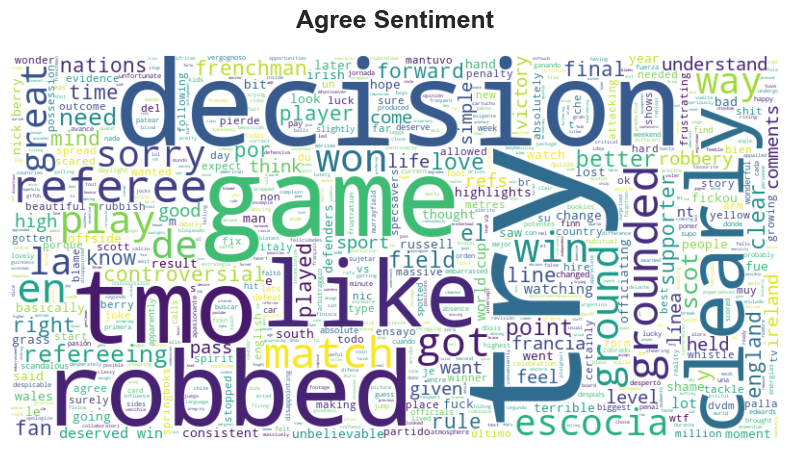

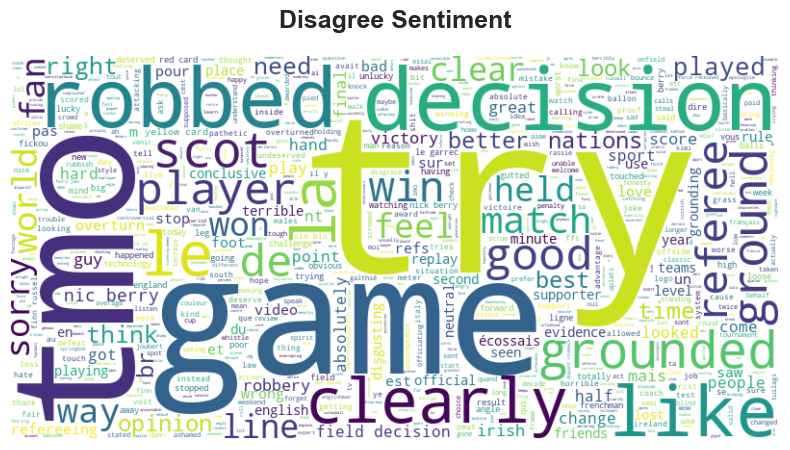

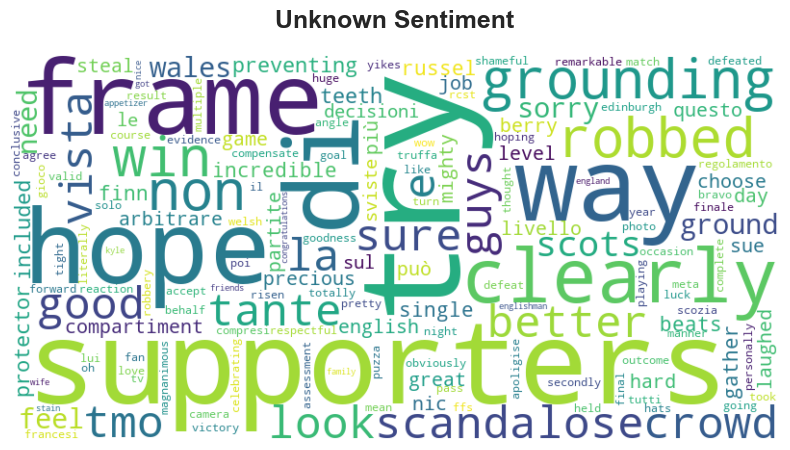

In [96]:
stopwords = ['Scotland','Scottish','France','French','ball','rugby','end','team','ref']
generate_word_cloud(reaction_df[reaction_df['Comment_Decision']=='Agree']['Comment'], 'Agree Sentiment', stopwords)
generate_word_cloud(reaction_df[reaction_df['Comment_Decision']=='Disagree']['Comment'], 'Disagree Sentiment', stopwords)
generate_word_cloud(reaction_df[reaction_df['Comment_Decision']=='Unknown']['Comment'], 'Unknown Sentiment', stopwords)